# Roche Capstone - Advanced Model Training (V2)

This notebook builds a machine learning model to predict experiment delays using the **Advanced (V2)** dataset. 
It incorporates complex features like **Machine Aging (Drift)** and **Reagent Batch Quality**.

## Objectives
1. **Data Fusion**: Merge Workflow, Reagent, and Telemetry logs.
2. **Feature Engineering**: Create `days_since_start` to capture drift.
3. **Model Selection**: Train Random Forest and Gradient Boosting.
4. **Interpretation**: Identify the "Bad Batches" and "Aging Instruments" via Feature Importance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set style
sns.set_style("whitegrid")

### 1. Data Loading & Feature Engineering

In [2]:
# Load Data
df_wk = pd.read_csv('workflow_logs.csv')
df_rg = pd.read_csv('reagent_logs.csv')
df_tl = pd.read_csv('telemetry_logs.csv')

# --- Merge ---
# We need Reagent Info and Ambient Temp
df_model = df_wk.merge(df_rg[['experiment_id', 'reagent_batch_id']], on='experiment_id', how='left')
df_model = df_model.merge(df_tl[['experiment_id', 'ambient_temp']], on='experiment_id', how='left')
df_model = df_model.rename(columns={'ambient_temp': 'mean_ambient_temp'}) # Consistency

# --- Time Drift Engineering ---
# The model needs to know "When" this happened to learn the machine degradation trend.
# We convert booking_time to "Days Since Start"
df_model['booking_time'] = pd.to_datetime(df_model['booking_time'])
start_date = df_model['booking_time'].min()
df_model['days_since_start'] = (df_model['booking_time'] - start_date).dt.days

# --- Target Handling ---
df_model = df_model.dropna(subset=['delay'])

print("Final Dataset Shape:", df_model.shape)
display(df_model.head())

Final Dataset Shape: (350000, 15)


,experiment_id,experiment_type,instrument_type,instrument_id,scientist_workload,scientist_experience_level,lab_occupancy_level,expected_duration,booking_time,actual_duration,delay,incident_type,reagent_batch_id,mean_ambient_temp,days_since_start
0,EXP_000000,Pilot,Incubator,Incubator_04,3,Junior,67,90,2024-01-01 00:18:04,98.721965,8.721965,NaN,BATCH_013,24.479079,0
1,EXP_000001,QC,Spectrometer,Spectrometer_04,4,Mid,64,45,2024-01-01 00:44:22,46.459434,1.459434,NaN,BATCH_016,21.194594,0
2,EXP_000002,QC,HPLC,HPLC_03,1,Senior,54,45,2024-01-01 01:05:07,62.299596,17.299596,NaN,BATCH_005,20.390660,0
3,EXP_000003,QC,Spectrometer,Spectrometer_01,5,Senior,61,45,2024-01-01 01:21:09,54.812713,9.812713,NaN,BATCH_046,24.307977,0
4,EXP_000004,Screening,PCR,PCR_00,6,Senior,86,30,2024-01-01 01:42:56,55.888540,25.888540,NaN,BATCH_034,23.124475,0


### 2. Preprocessing Pipeline

In [3]:
# Define Features
# removed 'priority_level' (not in V2)
# added 'reagent_batch_id' (Critical for Bad Batches)
# added 'days_since_start' (Critical for Drift)

NUM_FEATURES = ['scientist_workload', 'lab_occupancy_level', 'expected_duration', 'mean_ambient_temp', 'days_since_start']
CAT_FEATURES = ['experiment_type', 'instrument_type', 'scientist_experience_level', 'reagent_batch_id']
TARGET = 'delay'

X = df_model[NUM_FEATURES + CAT_FEATURES]
y = df_model[TARGET]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Transformers ---
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    # We OneHotEncode batch_id (50 values is fine for Tree models)
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, NUM_FEATURES),
        ('cat', cat_transformer, CAT_FEATURES)
    ]
)

print("Preprocessing Pipeline constructed.")

Preprocessing Pipeline constructed.


### 3. Model Training & Comparison

In [4]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []
trained_pipelines = {}

print("Starting Advanced Model Training...\n")

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])
    
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    # Evaluate
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({'Model': name, 'R2': r2, 'MAE': mae})
    trained_pipelines[name] = clf
    print(f"  -> R²: {r2:.4f}")

display(pd.DataFrame(results))

Starting Advanced Model Training...

Training Random Forest...
  -> R²: 0.8012
Training Gradient Boosting...
  -> R²: 0.8084


,Model,R2,MAE
0,Random Forest,0.801151,9.952398
1,Gradient Boosting,0.808406,9.765644


### 4. Interpretation: Opening the Black Box
Can the model see the Bad Batches and the Time Drift?

/var/folders/80/vx7bsx9917v8fw_1j_dc367h0000gn/T/ipykernel_55228/1662586508.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=imp_df, palette='rocket')


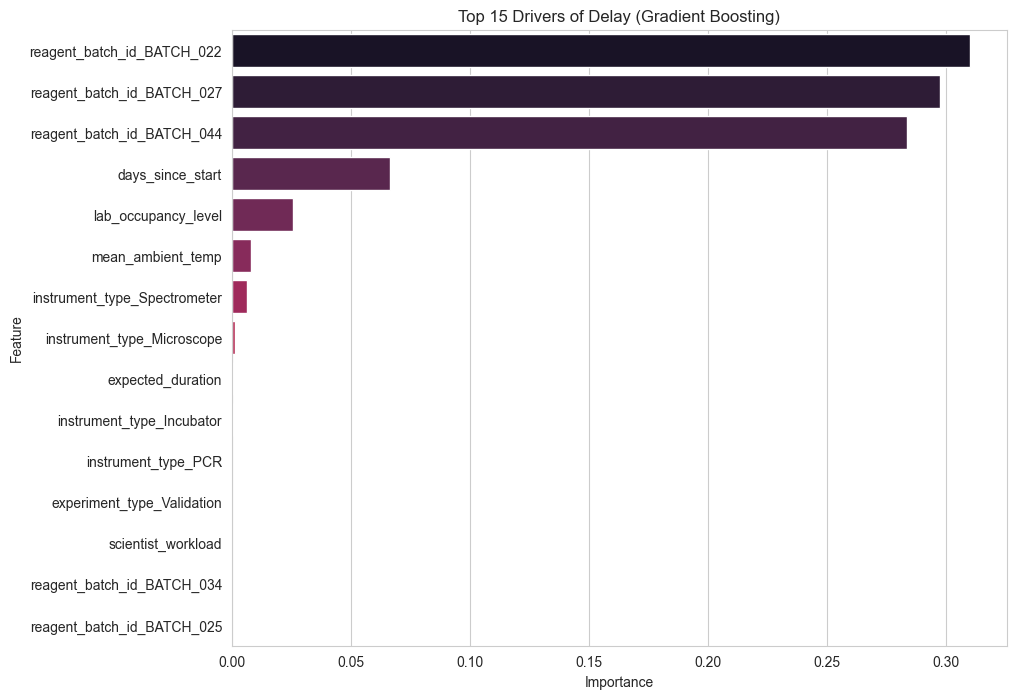

In [5]:
best_name = 'Gradient Boosting' # Usually better for complex interaction
best_model = trained_pipelines[best_name]

# Feature Importance
try:
    model_step = best_model.named_steps['model']
    importances = model_step.feature_importances_
    
    cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']['encoder']
    cat_names = cat_encoder.get_feature_names_out(CAT_FEATURES)
    feature_names = NUM_FEATURES + list(cat_names)
    
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    imp_df = imp_df.sort_values(by='Importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=imp_df, palette='rocket')
    plt.title(f'Top 15 Drivers of Delay ({best_name})')
    plt.show()
except Exception as e:
    print(f"Error plotting importance: {e}")

**Observation**:
-   Look for specific **reagent_batch_id_BATCH_XXX** in the top features. These are the models "learning" the bad batches.
-   **days_since_start** should also appear high up, indicating the model found the time drift.
-   **lab_occupancy_level** should remain a top driver.

In [6]:
# Save
joblib.dump(best_model, 'lab_delay_model_v2.pkl')
print("Model saved to 'lab_delay_model_v2.pkl'")

Model saved to 'lab_delay_model_v2.pkl'
